# 5.4 사이킷런 LinearRegression을 이용한 보스턴 주택 가격 예측

## LinearRegression을 이용해 보스턴 주택 가격 회귀 구현

In [2]:
#필요한 모듈 불러오기
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.datasets import load_boston
%matplotlib inline

#boston 데이터 세트 로드
boston = load_boston()

#boston 데이터 세트 DataFrame 변환
bostonDF = pd.DataFrame(boston.data, columns=boston.feature_names)

#boston 데이터 세트의 target 배열은 주택 가격임. 이를 PRICE 칼럼으로 DataFrame에 추가
bostonDF['PRICE'] = boston.target
print('Boston 데이터 세트 크기:', bostonDF.shape)
bostonDF.head()

Boston 데이터 세트 크기: (506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [3]:
bostonDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  PRICE    506 non-null    float64
dtypes: float64(14)
memory usage: 55.5 KB


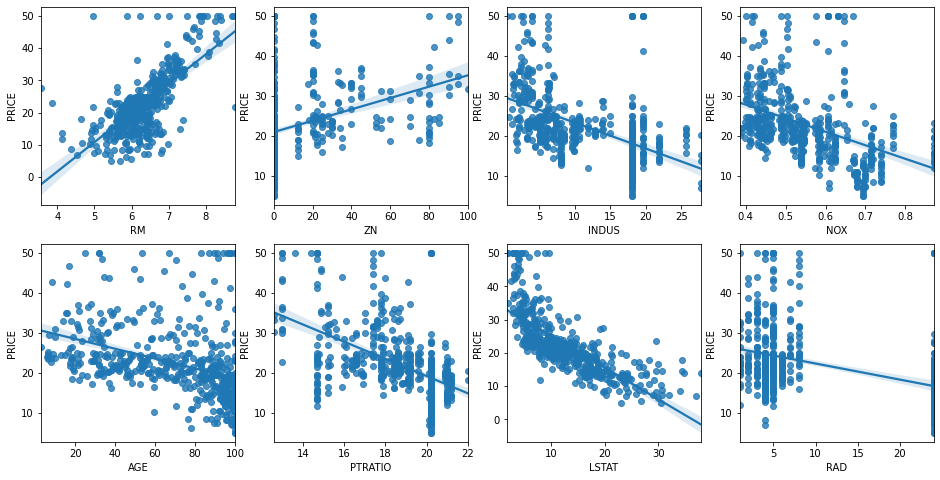

In [6]:
#각 칼럼이 회귀 결과에 미치는 영향 시각화

#8개 칼럼이므로 2개의 행과 4개의 열을 가진 subplots를 이용. axs는 4x2의 ax를 가짐.
fig, axs = plt.subplots(figsize=(16,8), ncols=4, nrows=2)
lm_features = ['RM', 'ZN', 'INDUS', 'NOX', 'AGE', 'PTRATIO', 'LSTAT', 'RAD']
for i, feature in enumerate(lm_features):
    row = int(i/4)    #row=i//4 로 해도 된다.
    col = i%4
    #시본의 regplot을 이용해 산점도와 선형 회귀 직선을 함께 표현
    sns.regplot(x=feature, y='PRICE', data=bostonDF, ax=axs[row][col])

In [7]:
#LinearRegression 클래스를 이용해 보스턴 주택 가격의 회귀 모델 만들기

#필요한 모듈 불러오기
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

#학습/테스트용 데이터 세트 분리
y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'], axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, test_size=0.3, random_state=156)

#선형 회귀 OLS로 학습/예측/평가 수행
lr = LinearRegression()
lr.fit(X_train, y_train)
y_preds = lr.predict(X_test)
mse = mean_squared_error(y_test, y_preds)
rmse = np.sqrt(mse)

#MSE, RMSE 확인
print('MSE: {0:.3f}, RMSE: {1:.3f}'.format(mse, rmse))
print('Variance score: {0:.3f}'.format(r2_score(y_test, y_preds)))

MSE: 17.297, RMSE: 4.159
Variance score: 0.757


In [8]:
#intercept(절편), coefficients(회귀 계수) 확인
print('절편 값:', lr.intercept_)
print('회귀 계수값:', np.round(lr.coef_, 1))

절편 값: 40.99559517216454
회귀 계수값: [ -0.1   0.1   0.    3.  -19.8   3.4   0.   -1.7   0.4  -0.   -0.9   0.
  -0.6]


In [9]:
#회귀 계수를 큰 값 순으로 정렬하기 위해 Series로 생성. 인덱스 칼럼명에 유의
coeff = pd.Series(data=np.round(lr.coef_, 1), index=X_data.columns)
coeff.sort_values(ascending=False)

RM          3.4
CHAS        3.0
RAD         0.4
ZN          0.1
B           0.0
TAX        -0.0
AGE         0.0
INDUS       0.0
CRIM       -0.1
LSTAT      -0.6
PTRATIO    -0.9
DIS        -1.7
NOX       -19.8
dtype: float64

In [11]:
#최적화 수행하며 피처 coefficients 변화도 같이 살펴볼 것.
#5개 폴드 세트에서 cross_val_score()를 이용해 교차 검증으로 MSE와 RMSE 측정
#인자로 scoring='neg_mean_squared_error' 지정. 반환값이 음수임을 주의

from sklearn.model_selection import cross_val_score

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'], axis=1, inplace=False)
lr = LinearRegression()

#cross_val_score()로 5 폴드 세트로 MSE 구한 뒤 이를 기반으로 다시 RMSE 구함.
neg_mse_scores = cross_val_score(lr, X_data, y_target, scoring='neg_mean_squared_error', cv=5)
rmse_scores = np.sqrt(-1*neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

#cross_val_score(scoring='neg_mean_squared_error')로 반환된 값은 모두 음수
print('5 folds의 개별 Negative MSE scores:', np.round(neg_mse_scores, 2))
print('5 folds의 개별 RMSE scores:', np.round(rmse_scores, 2))
print('5 folds의 평균 RMSE: {0:.3f}'.format(avg_rmse))

5 folds의 개별 Negative MSE scores: [-12.46 -26.05 -33.07 -80.76 -33.31]
5 folds의 개별 RMSE scores: [3.53 5.1  5.75 8.99 5.77]
5 folds의 평균 RMSE: 5.829


# 5.5 다항 회귀와 과(대)적합/과소적합 이해
## 다항 회귀 이해

In [12]:
#PolynomialFeatures 클래스를 이용해 단항값을 이차 다항값으로 변환하는 예제
from sklearn.preprocessing import PolynomialFeatures
import numpy as np

#다항식으로 변환한 단항식 생성, [[0,1],[2,3]]의 2x2 행렬 생성
X = np.arange(4).reshape(2,2)
print('일차 단항식 계수 피처:\n',X)

#degree=2인 2차 다항식으로 변환하기 위해 PolynomialFeatures를 이용해 변환
poly = PolynomialFeatures(degree=2)
poly.fit(X)
poly_ftr = poly.transform(X)
print('변환된 2차 다항식 계수 피처:\n', poly_ftr)

일차 단항식 계수 피처:
 [[0 1]
 [2 3]]
변환된 2차 다항식 계수 피처:
 [[1. 0. 1. 0. 0. 1.]
 [1. 2. 3. 4. 6. 9.]]


In [14]:
#3차 다항 회귀 함수를 설정한 후 회귀 계수 예측

#3차 함수식
def polynomial_func(X):
    y = 1 + 2*X[:,0] + 3*X[:,0]**2 + 4*X[:,1]**3
    return y

#일차 단항식 계수 생성 후 삼차 다항식 결정값 출력
X = np.arange(4).reshape(2,2)
print('일차 단항식 계수 feature: \n', X)
y = polynomial_func(X)
print('삼차 다항식 결정값: \n', y)

일차 단항식 계수 feature: 
 [[0 1]
 [2 3]]
삼차 다항식 결정값: 
 [  5 125]


In [15]:
#일차 단항식 계수를 3차 다항식 계수로 변환
poly_ftr = PolynomialFeatures(degree=3).fit_transform(X)
print('3차 다항식 계수 feature:\n', poly_ftr)

#LinearRegression에 3차 다항식 계수 feature와 3차 다항식 결정값으로 학습 후 회귀 계수 확인
model = LinearRegression()
model.fit(poly_ftr, y)
print('Polynomial 회귀 계수\n', np.round(model.coef_,2))
print('Polynomial 회귀 shape:', model.coef_.shape)

3차 다항식 계수 feature:
 [[ 1.  0.  1.  0.  0.  1.  0.  0.  0.  1.]
 [ 1.  2.  3.  4.  6.  9.  8. 12. 18. 27.]]
Polynomial 회귀 계수
 [0.   0.18 0.18 0.36 0.54 0.72 0.72 1.08 1.62 2.34]
Polynomial 회귀 shape: (10,)


In [16]:
#사이킷런의 Pipeline 객체로 한 번에 다항 회귀 구현 (not 피처 변환 + 선형 회귀 적용)
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
import numpy as np

def polynomial_func(X):
    y = 1 + 2*X[:,0] + 3*X[:,0]**2 + 4*X[:,1]**3
    return y

#Pipeline 객체로 Streamline하게 Polynomial Feature 변환과 Linear Regression을 연결
model = Pipeline([('poly', PolynomialFeatures(degree=3)),
                 ('linear', LinearRegression())])
X = np.arange(4).reshape(2,2)
y = polynomial_func(X)

model = model.fit(X,y)
print('Polynomial 회귀 계수\n', np.round(model.named_steps['linear'].coef_, 2))

Polynomial 회귀 계수
 [0.   0.18 0.18 0.36 0.54 0.72 0.72 1.08 1.62 2.34]


## 다항 회귀를 이용한 과소적합 및 과적합 이해

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
%matplotlib inline

#임의의 값으로 구성된 X값에 대해 코사인 변환 값을 반환
def true_fun(X):
    return np.cos(1.5*np.pi*X)

#X는 0부터 1까지 30개의 임의의 값을 순서대로 샘플링한 데이터입니다.
np.random.seed(0)
n_samples = 30
X = np.sort(np.random.rand(n_samples))

#y값은 코사인 기반의 true_fun()에서 약간의 노이즈 변동 값을 더한 값입니다.
y = true_fun(X) + np.random.randn(n_samples)*0.1


Degree 1 회귀 계수는 [-1.61] 입니다.
Degree 1 MSE는 0.40772896250986845 입니다.

Degree 4 회귀 계수는 [  0.47 -17.79  23.59  -7.26] 입니다.
Degree 4 MSE는 0.043208749872317556 입니다.

Degree 15 회귀 계수는 [-2.98295000e+03  1.03900050e+05 -1.87417308e+06  2.03717524e+07
 -1.44874234e+08  7.09320168e+08 -2.47067524e+09  6.24565587e+09
 -1.15677381e+10  1.56896159e+10 -1.54007266e+10  1.06458152e+10
 -4.91381762e+09  1.35920853e+09 -1.70382347e+08] 입니다.
Degree 15 MSE는 181777900.10696036 입니다.


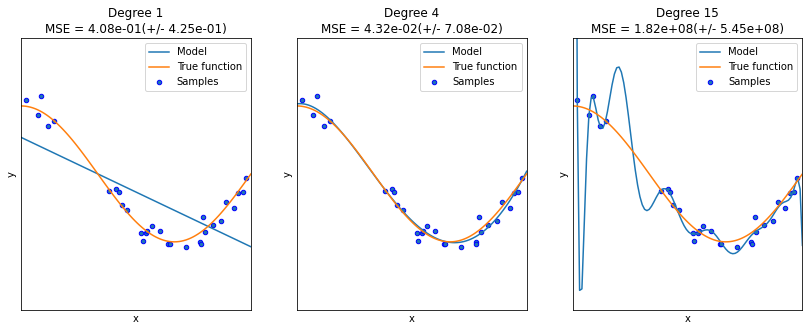

In [27]:
#다항식 차수를 1, 4, 15로 변경하면서 예측 결과 비교
#다항식 차수별로 학습 수행 후 cross_val_score()로 MSE값 구해 차수별 예측 성능 평가
#0부터 1까지 균일하게 구성된 100개 테스트용 데이터 세트로 차수별 회귀 예측 곡선 그려볼 것.

plt.figure(figsize=(14,5))
degrees = [1,4,15]

#다항 회귀의 차수(degree)를 1, 4, 15로 각각 변화시키면서 비교합니다.
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i+1)
    plt.setp(ax, xticks=(), yticks=())
    
    #개별 degree별로 Polynomial 변환합니다.
    polynomial_features = PolynomialFeatures(degree=degrees[i], include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([('polynomial_features', polynomial_features),
                        ('linear_regression', linear_regression)])
    pipeline.fit(X.reshape(-1,1),y)
    
    #교차 검증으로 다항 회귀를 평가합니다.
    scores = cross_val_score(pipeline, X.reshape(-1,1), y, scoring='neg_mean_squared_error', cv=10)
    #Pipeline을 구성하는 세부 객체를 접근하는 named_steps['객체명']을 이용해 회귀계수 추출
    coefficients = pipeline.named_steps['linear_regression'].coef_
    print('\nDegree {0} 회귀 계수는 {1} 입니다.'.format(degrees[i], np.round(coefficients,2)))
    print('Degree {0} MSE는 {1} 입니다.'.format(degrees[i], -1*np.mean(scores)))
    
    #0부터 1까지 테스트 데이터 세트를 100개로 나누어 예측을 수행합니다.
    #테스트 데이터 세트에 회귀 예측을 수행하고 예측 곡선과 실제 곡선을 그려서 비교합니다.
    X_test = np.linspace(0,1,100)
    #예측값 곡선
    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label='Model')
    #실제값 곡선
    plt.plot(X_test, true_fun(X_test), '-', label='True function')
    plt.scatter(X, y, edgecolor='b', s=20, label='Samples')
    
    plt.xlabel('x'); plt.ylabel('y'); plt.xlim((0,1)); plt.ylim((-2,2)); plt.legend(loc='best')
    plt.title('Degree {}\nMSE = {:.2e}(+/- {:.2e})'.format(degrees[i], -scores.mean(), scores.std()))

plt.show()